<a href="https://colab.research.google.com/github/KokiYamanaka/001-Cat-classifier-from-scratch-/blob/main/cat_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cat/Non-Cat?**

A simple logistic regression classifier to recognize cats.

Created by : Koki Yamanaka

In [ ]:
pip install opencv-python

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
from public_tests import *
import cv2

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we load a predefined dataset. And, display a couple images what training set data looks like. Note: supervised task, means cat images are labelled with bounding boxes

In [ ]:
# Loading the data (cat/non-cat)
# training set images contained labeled cat(y=1)/dog(y=0)
# test set contain cats/dogs images
# note that : this data is well supervised (well labelled)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

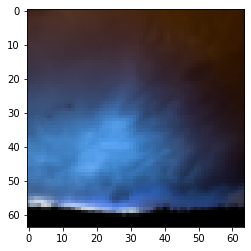

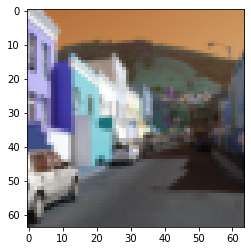

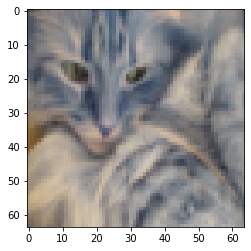

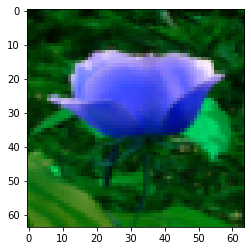

In [ ]:
# show a few example of a train set 
for i in range(4): 
    img = train_set_x_orig[i]
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    plt.show()

Next, we explore input/output's dimension size. This helps gain intuition on what you're working on and reduce making error. (since dimension error frequently during later machinery)
 

In [ ]:
First, we load a predefined dataset. And, display a couple images what training set data looks like. Note: supervised task, means cat images are labelled with bounding boxes# double check shape for number training examples, test examples, height/width pixel size 
print("test shape, output shape: ",test_set_y.shape, classes.shape) # (1,50) - 50 output neuron check prob  AND (2,) - binary logistic output 
print("what a train set look like encode vector look like","\n",train_set_y)
print("what a binary output look like","\n",classes)

train_example_size = train_set_x_orig.shape[0] # 209 (0.76%)
test_example_size = test_set_x_orig.shape[0] # 50 (0.23%)
pixel_size = train_set_x_orig.shape[1] # 64x64
print("train example size, test example size, pixel size (hxw) :",train_example_size,test_example_size,pixel_size)

test shape, output shape:  (1, 50) (2,)
what a train set look like encode vector look like 
 [[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1
  1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0
  1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1
  0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]]
what a binary output look like 
 [b'non-cat' b'cat']
train example size, test example size, pixel size (hxw) : 209 50 64


We need to flatten each image, which is 64x64 pixels in 3 RGB channels, into a single flatten row vector. <br>
note : (lesson learned) Computation machinery is more efficient when represented in numerical matrix.

In [ ]:
# flatten image matrix into single vector 
print("before flatten: " + str(train_set_x_orig.shape),str(test_set_x_orig.shape))
train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T  # note: 64x64x3 = 12288, 209 = num examples
test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
print("after flatten: " +  str(train_set_x_orig.shape)+ str(test_set_x_orig.shape) ) 
print("unchanged: " + str(train_set_y.shape) +str(test_set_y.shape))

before flatten: (209, 64, 64, 3) (50, 64, 64, 3)
after flatten: (12288, 209)(12288, 50)
unchanged: (1, 209)(1, 50)


Every single component for each image is stardardized into a value between 0 to 1 to make computation more efficient. 

In [ ]:
# standardize flattened vector's component for better training 
train_set_x_orig = train_set_x_orig / 255.
test_set_x_orig = test_set_x_orig / 255.
print("testing:",train_set_x_orig)

testing: [[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]


This function is to compute the probability of an image between cat/non-cat at the final layer. We also create a threshold of 0.5 to differentiate whether the image belongs to cat/non-cat boundary.<br>
Note : 
This function can be replaced by other types, if we have different type of task. (class output more than 2,transfer learning)

In [ ]:
# build sigmoid function to compute probability of cat/non-cat (range[0,1])
def sigmoid(x): 
    return 1/(1 + np.exp(-x)) # x below 0, then prob <= 0.5 // if above 0, then prob >= 0.5
print("testing "+str(sigmoid(np.array([-0.01,0,2,5,99]))))

testing [0.49750002 0.5        0.88079708 0.99330715 1.        ]


We initialize the weights with random values between 0 and 1 and the biases with zeros (auto-boxing applied). 
<br>These weight are multiply by value assigned in each single neuron and added with biases. 

In [ ]:
# initialize weights and biases 
def parameter_initializer(dimension):
    w = np.random.randn(dimension,1)
    b = np.float()
    return w,b
print("testing "+str(parameter_initializer(dimension=2)))

testing (array([[0.25478128],
       [0.05933493]]), 0.0)


This section, we proceed forward propagation. <br>Every computed nodes/weights/biases will ended up as an x input for sigmoid function to get activation.<br> Cost function is build to calculate the difference between predicted and actual output. <br>Add on, a specialized cost function is used to suit logistic task here. 

In [ ]:
# compute weight and bias towards right side, it's cost gradient  
def propagate(w,b,x,y): 
    
    # define training examples
    m_example = x.shape[1]
    
    # compute activation function
    activation = sigmoid(np.dot(w.T,x)+b)
    
    # compute cost function 
    cost = -1./m_example* np.sum(y*np.log(activation) + (1-y)*np.log(1-activation))  
    
    # compute weight and bias gradients
    d_weight = 1./m_example*np.dot(x, (activation-y).T)
    d_biases = 1./m_example*np.sum(activation-y)
    
    # different set to find gradients
    gradient = {"dw": d_weight,
             "db": d_biases}
    
    return gradient,cost

w, b, x, y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
print(x.shape)
print("gradient and cost :", propagate(w,b,x,y))

(2, 2)
gradient and cost : ({'dw': array([[0.99993216],
       [1.99980262]]), 'db': 0.49993523062470574}, 6.000064773192205)


The main purpose here is to find the suitable/optimal w weight in a real number interval so that model becomes accurate predicting. 
*   First, gradient and cost function is pre-calculated with previous function.
*   Then, new weight value is iterate/found as gradient approaches to a local minimum/optimal.
*   Gradient may overshoot/overpass local minimum
*   Thus, learning rate value, which defines speed of iteration for searching new weight, is predefined to avoid overshoot.
*   Same theory for biases

most intuitive explanation : 
[link](https://www.youtube.com/watch?v=khUVIZ3MON8&t=314s)

In [ ]:
def update_parameter(w, b, x,y, num_iterations, learning_rate):
    costs = []
    # iterate through training examples 
    for i in range(num_iterations):
        
        # compute gradient and cost
        gradient, cost =  propagate(w,b,x,y)
        
        # update new weight and bias to find local minimum 
        w = w - learning_rate*gradient["dw"]  
        b = b - learning_rate*gradient["db"]
        
    # subset parameter and gradient for specify purpose 
    parameter = {"w": w,
              "b": b}
    gradient = {"dw": gradient["dw"],
             "db": gradient["db"]}
    
    
    return parameter,gradient

w, b,x,y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]]) # given weight and bias
parameter , gradient = update_parameter(w, b, x,y, num_iterations= 100, learning_rate = 0.009) # computed new weight/bias and gradients
print("new weight: ",str(parameter["w"]))
print("new bias  : ",str(parameter["b"]))
print("new gradient ",gradient)

new weight:  [[0.1124579 ]
 [0.23106775]]
new bias  :  1.5593049248448891
new gradient  {'dw': array([[0.90158428],
       [1.76250842]]), 'db': 0.4304620716786828}


This section computes activation in a value form of binary (cat/non-cat) <br> If an image exists the probability of below 0.5, then we label the image as non-cat (y=0), vica-versa.

In [ ]:
# predict new input 
def predict(w, b, x):
    m = x.shape[1]
    y_predict = np.zeros((1, m))
    w = w.reshape(x.shape[0], 1)
    
    # compute activation 
    activation = sigmoid(np.dot(w.T,x)+b)# yhat = activation
    
    # convert y prediction to binary (0,1), threshold 0.5
    for i in range(activation.shape[1]):
        if activation[0, i] > 0.5:
            y_predict[0, i] = 1
        else:
             y_predict[0, i] = 0
                
    return  y_predict    

w, b,x,y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]]) # given weight/bias/input/output
print ("current predictions" + str(predict(w, b, x)))

current predictions[[1. 1.]]


We finally merge all the component into one single model to train. The model uses set of 76% of train data and 24% of test data. 

In [ ]:
# merging all components to build model 
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5):
    w,b = parameter_initializer(X_train.shape[0])
    params,grads = update_parameter(w, b, X_train, Y_train, num_iterations, learning_rate)
    w = params['w']
    b = params['b']
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
     
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    return Y_prediction_test
model = model(train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, num_iterations=2000, learning_rate=0.5)

train accuracy: 100.0 %
test accuracy: 70.0 %


The following will use the model to train on some test set. First line will indicate the actual expect output, while 2nd will show the actual predicted output.

this picture is labelled as y =  0
our model predicted as :  0.0


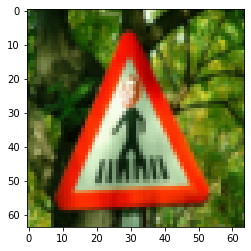

In [ ]:
# predict an image is cat/non-cat ? 

# test -1
index = 14
plt.imshow(test_set_x_orig[:,index].reshape((num_px, num_px, 3)))
print("this picture is labelled as y = ",str(test_set_y[0, index]))
print("our model predicted as : ", model[0,index])

this picture is labelled as y =  1
our model predicted as :  1.0


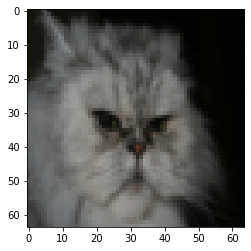

In [ ]:
# test-2
index = 12
plt.imshow(test_set_x_orig[:,index].reshape((num_px, num_px, 3)))
print("this picture is labelled as y = ",str(test_set_y[0, index])) #
print("our model predicted as : ", model[0,index])

this picture is labelled as y =  1
our model predicted as :  1.0


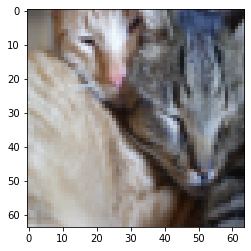

In [ ]:
# test-3 
index = 37
plt.imshow(test_set_x_orig[:,index].reshape((num_px, num_px, 3)))
print("this picture is labelled as y = ",str(test_set_y[0, index])) #
print("our model predicted as : ", model[0,index])

this picture is labelled as y =  0
our model predicted as :  0.0


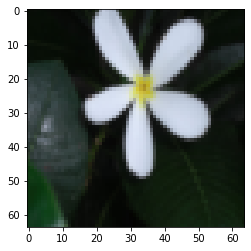

In [ ]:
# test- 4 
index = 39
plt.imshow(test_set_x_orig[:,index].reshape((num_px, num_px, 3)))
print("this picture is labelled as y = ",str(test_set_y[0, index])) #
print("our model predicted as : ", model[0,index])

# Extras : experiment/visualize 
Code block everything below is some experiment to build forward propagation in a different way.
<br>This section is a network of 1 input, 1 hidden layer, and a single output. Each layer consists of 2 nodes. Note that, value of weight/bias are simple, so that it is easy to gain inner machinery of propagation.

In [ ]:
# Implement a propagate algorithm to computes the cost function and its gradient.
# -testing from small scale network
def propagate_2(w,x,):
    #z1 = np.dot(w,x)
    node1_value = (x*w['node1']).sum()
    node2_value = (x*w['node2']).sum()
    
    hidden_layer_val = np.array([node1_value,node2_value])
    final_layer_val = (hidden_layer_val*w['node3']).sum()
    
    # final layer to wrap up with sigmoid 
    activation = sigmoid(final_layer_val) # output probability 
 
    # minimize lost function = backpropagate = d(loss) / d(weight) = update weights 
    # increase value of accurate final_node , decrease value not accurate
    
    return activation

In [ ]:
x = np.array([2,3])
w = {'node1':np.array([1,1]),'node2':np.array([-1,1]),'node3':np.array([2,-1])} # from upper to bottom 
print("testing use")
propagate_2(w ,x)

testing use


0.9998766054240137

This is another different architecture of forward propagation and parameter optimzer. <br> The highlight here is that we use a standard and intuitive lost function "(activation-actual output)**2 ". 

In [ ]:
# experiment one output, one input NN 
def propage_2(x,w,desired_output):
    # compute activation and cost function 
    activation = x*w
    cost = (activation - desired_output)**2
 
    # find formula for gradient (dc/dw)  
    da_dw = x 
    dc_da = 2*(activation-desired_output) 
    dc_dw = (da_dw)*(dc_da) 
    
    # dc_db =  # compute g/d for bias 
    return activation,cost,dc_dw

# find new optimized weight value to reduce cost value  
def update_parameter(learning_rate,dc_dw,prev_weight,num_iterations,desired_output,x):
    
    for i in range(num_iterations):
        # update weights to find local minimum to reduce cost
        new_weight = prev_weight - learning_rate*dc_dw # overshoot weight happens (weight pass over local minimum)
        prev_weight = new_weight  
        print("updated weight" ,str(i)+":", prev_weight)
        
        # compute new cost
        activation = x*prev_weight
        new_cost = (activation - desired_output)**2
        print("updated cost" ,str(i)+":", new_cost,"\n")
        
    
    return None

This section output the above machinery, which update new weights and spits out the updated new cost for each iteration.<br> Note that the optimize computation for weight and cost overshoot the local minimum after 2nd iteration. 

In [ ]:
print("this section is for experiment purpose")
x = 1.5 
w = 0.8 
desired_output = 0.5
activation,cost,dc_dw = propage_2(x,w,desired_output)
print("current cost : ",cost,"\n")

print("each epoch")
update_parameter(0.1,dc_dw,w,5,desired_output,x)

print("note : 2 epoch contain best weight, while 3rd overshoots")

this section is for experiment purpose
current cost :  0.49000000000000027 

each epoch
updated weight 0: 0.59
updated cost 0: 0.148225 

updated weight 1: 0.3799999999999999
updated cost 1: 0.004899999999999977 

updated weight 2: 0.16999999999999982
updated cost 2: 0.060025000000000134 

updated weight 3: -0.04000000000000026
updated cost 3: 0.31360000000000043 

updated weight 4: -0.25000000000000033
updated cost 4: 0.7656250000000008 

note : 2 epoch contain best weight, while 3rd overshoots


End line of code